# Faster-RCNN Finetuning Tutorial

For this tutorial, we will finetune a pre-trained Faster-RCNN model on the [Penn-Fudan Database for Pedestrian Detection and Segmentation](https://www.cis.upenn.edu/~jshi/ped_html/). It contains 170 images with 345 instances of pedestrians, and we will use it to illustrate how to use the new features in torchvision in order to train an object detection and instance segmentation model on a custom dataset.

**Note:**
*   recommend *torchvision* version >=0.16



## Dataset preparation


### 1. Download the Dataset
First, let’s download the Pedestrian dataset and extract the zip file:


In [1]:
!wget https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip -P data
!cd data && unzip PennFudanPed.zip

'wget' �����ڲ����ⲿ���Ҳ���ǿ����еĳ���
���������ļ���
ϵͳ�Ҳ���ָ����·����


We have the following folder structure:

PennFudanPed/


*   PedMasks/



    FudanPed00001_mask.png
    FudanPed00002_mask.png
    FudanPed00003_mask.png
    FudanPed00004_mask.png
    ...
*   PNGImages/


    FudanPed00001.png
    FudanPed00002.png
    FudanPed00003.png
    FudanPed00004.png
    ...

### 2. Display an example of a pair of images and segmentation masks:

As shown in the following image and mask, each image has a corresponding segmentation mask, where each color correspond to a different instance.

In [ ]:
import matplotlib.pyplot as plt
from torchvision.io import read_image


image = read_image("data/PennFudanPed/PNGImages/FudanPed00046.png")
mask = read_image("data/PennFudanPed/PedMasks/FudanPed00046_mask.png")

plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.title("Image")
plt.imshow(image.permute(1, 2, 0))
plt.subplot(122)
plt.title("Mask")
plt.imshow(mask.permute(1, 2, 0))

RuntimeError: [Errno 2] No such file or directory: '~/.cache./PennFudanPed/PNGImages/FudanPed00046.png'

### 3. Define the Dataset
Next, we need to write a class for this dataset. As the code below, we wrap images, bounding boxes and masks into torchvision.tv_tensors. The dataset should inherit from the standard [torch.utils.data.Dataset](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset) class, and implement **\_\_ len__** and **\_\_getitem__**.

the dataset **\_\_getitem__** should return a tuple:
*   **image**: [torchvision.tv_tensors.Image](https://pytorch.org/vision/stable/generated/torchvision.tv_tensors.BoundingBoxes.html#torchvision.tv_tensors.BoundingBoxes) of shape [3, H, W], a pure tensor, or a PIL Image of size (H, W)
*   **target**: a dict containing the following fields:

  *   boxes, [torchvision.tv_tensors.BoundingBoxes](https://pytorch.org/vision/stable/generated/torchvision.tv_tensors.BoundingBoxes.html#torchvision.tv_tensors.BoundingBoxes) of shape [N, 4]: the coordinates of the N bounding boxes in [x0, y0, x1, y1] format, ranging from 0 to W and 0 to H
  *   labels, integer [torch.Tensor](https://pytorch.org/docs/stable/tensors.html#torch.Tensor) of shape [N]: the label for each bounding box. 0 represents always the background class.
  * image_id, int: an image identifier. It should be unique between all the images in the dataset, and is used during evaluation.
  * area, float [torch.Tensor](https://pytorch.org/docs/stable/tensors.html#torch.Tensor) of shape [N]: the area of the bounding box. This is used during evaluation with the COCO metric, to separate the metric scores between small, medium and large boxes.
  * iscrowd, uint8 [torch.Tensor](https://pytorch.org/docs/stable/tensors.html#torch.Tensor) of shape [N]: instances with iscrowd=True will be ignored during evaluation.
  * (optionally) masks, [torchvision.tv_tensors.Mask](https://pytorch.org/vision/stable/generated/torchvision.tv_tensors.Mask.html#torchvision.tv_tensors.Mask) of shape [N, H, W]: the segmentation masks for each one of the objects.

In [ ]:
import os
import torch

from torchvision.io import read_image
from torchvision.ops.boxes import masks_to_boxes
from torchvision import tv_tensors
from torchvision.transforms.v2 import functional as F


class PennFudanDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms):
        '''
        Initialize the dataset
        Args:
            root (str): Root directory of the dataset
            transforms: Transformations to be applied to images and targets
        '''
        self.root = root
        self.transforms = transforms
        # Get sorted lists of image and mask filenames to ensure alignment
        self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))

    def __getitem__(self, idx):
        '''
        Get a single sample from the dataset
        Args: idx (int): Index of the sample to fetch
        Returns: tuple: (image, target) where target is a dictionary of annotations
        '''
        # Construct full paths and load image and mask
        img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
        mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
        img = read_image(img_path)
        mask = read_image(mask_path)
        # Get unique object IDs from the mask
        # Each different color in mask represents a different instance
        obj_ids = torch.unique(mask)
        # Remove background ID (0)
        obj_ids = obj_ids[1:]
        num_objs = len(obj_ids)

        # Create binary masks for each instance
        # Shape: [num_instances, height, width]
        masks = (mask == obj_ids[:, None, None]).to(dtype=torch.uint8)

        # Convert instance masks to bounding boxes
        boxes = masks_to_boxes(masks)

        # Create labels tensor (all 1s as there's only one class - pedestrian)
        labels = torch.ones((num_objs,), dtype=torch.int64)

        # Additional target information
        image_id = idx
        # Calculate area of each bounding box
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # Set iscrowd flag to 0 for all instances
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        # Wrap sample and targets into torchvision tv_tensors:
        img = tv_tensors.Image(img)

        # Create target dictionary with all annotations
        target = {}
        target["boxes"] = tv_tensors.BoundingBoxes(boxes, format="XYXY", canvas_size=F.get_size(img))
        target["masks"] = tv_tensors.Mask(masks)
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

## Finetuning from a pretrained model

### Download the pretrained model

Here we want to also compute the instance segmentation masks, so we will load a pre-trained Mask R-CNN:

In [ ]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor


def get_model_instance_segmentation(num_classes):
    # Load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights="DEFAULT")

    # Get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # Replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # Now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # Replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(
        in_features_mask,
        hidden_layer,
        num_classes
    )

    return model

### Download the  helper functions provided by PyTorch for training and evaluating detection models.

* **engine.py**: Contains training and evaluation loops
* **utils.py**: Contains utility functions
* **coco_utils.py**: Contains COCO dataset related utilities
* **coco_eval.py**: Contains COCO evaluation metrics
* **transforms.py**: Contains data transformation functions

In [ ]:
# Download the required files from PyTorch vision repository
import os
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/engine.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/utils.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_utils.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_eval.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/transforms.py")

0

### Define the helper functions transformation:

In [ ]:
from torchvision.transforms import v2 as T


def get_transform(train):
    """
    Creates a data transformation pipeline for image preprocessing and augmentation.

    Args:
        train (bool): Indicates whether the transformation is for training.
                      If True, data augmentation is applied.

    Returns:
        T.Compose: A composed transformation pipeline.
    """
    transforms = []
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    transforms.append(T.ToDtype(torch.float, scale=True))
    transforms.append(T.ToPureTensor())
    return T.Compose(transforms)

### Define the main function which performs the training and the validation

In [ ]:
import utils
from engine import train_one_epoch, evaluate

# Train on the GPU or on the CPU, if a GPU is not available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Define number of classes for the model
# In this case: class 0 for background, class 1 for person
num_classes = 2
# Initialize datasets for training and testing
dataset = PennFudanDataset('data/PennFudanPed', get_transform(train=True))
dataset_test = PennFudanDataset('data/PennFudanPed', get_transform(train=False))

# Split the dataset in train and test set(Last 50 samples are used for testing)
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-50])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

# Define DataLoader for training set
# shuffle=True to randomize training samples
data_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=2,
    shuffle=True,
    collate_fn=utils.collate_fn
)

# Define DataLoader for Test set
# shuffle=False to maintain consistency in testing
data_loader_test = torch.utils.data.DataLoader(
    dataset_test,
    batch_size=1,
    shuffle=False,
    collate_fn=utils.collate_fn
)

# Get the model using our helper function
model = get_model_instance_segmentation(num_classes)

# Move model to the right device
model.to(device)

# Set up optimizer
# Only include parameters that require gradients
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(
    params,
    lr=0.005,
    momentum=0.9,
    weight_decay=0.0005 # L2 regularization
)

# Set up learning rate scheduler
# Reduces learning rate by factor of 0.1 every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=3,
    gamma=0.1
)

# Training loop
num_epochs = 2

for epoch in range(num_epochs):
    # Train for one epoch, printing every 20 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=20)
    # Update the learning rate
    lr_scheduler.step()
    # Evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

print("Finetune completed!")

Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth
100%|██████████| 170M/170M [00:03<00:00, 49.0MB/s]
/content/engine.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=scaler is not None):


Epoch: [0]  [ 0/60]  eta: 0:03:00  lr: 0.000090  loss: 7.1773 (7.1773)  loss_classifier: 1.1068 (1.1068)  loss_box_reg: 0.4356 (0.4356)  loss_mask: 5.6156 (5.6156)  loss_objectness: 0.0123 (0.0123)  loss_rpn_box_reg: 0.0071 (0.0071)  time: 3.0071  data: 0.0871  max mem: 2508
Epoch: [0]  [20/60]  eta: 0:00:27  lr: 0.001783  loss: 1.0327 (2.1893)  loss_classifier: 0.2437 (0.4313)  loss_box_reg: 0.2298 (0.2650)  loss_mask: 0.4702 (1.4658)  loss_objectness: 0.0153 (0.0211)  loss_rpn_box_reg: 0.0054 (0.0061)  time: 0.5766  data: 0.0402  max mem: 2763
Epoch: [0]  [40/60]  eta: 0:00:12  lr: 0.003476  loss: 0.5205 (1.3992)  loss_classifier: 0.0865 (0.2699)  loss_box_reg: 0.1906 (0.2380)  loss_mask: 0.2367 (0.8678)  loss_objectness: 0.0061 (0.0151)  loss_rpn_box_reg: 0.0062 (0.0083)  time: 0.5304  data: 0.0290  max mem: 2826
Epoch: [0]  [59/60]  eta: 0:00:00  lr: 0.005000  loss: 0.3747 (1.0919)  loss_classifier: 0.0459 (0.2018)  loss_box_reg: 0.1567 (0.2242)  loss_mask: 0.1653 (0.6459)  loss_ob

## Display the performance on the Test Set
Here we take an image from the dataset as a test sample.

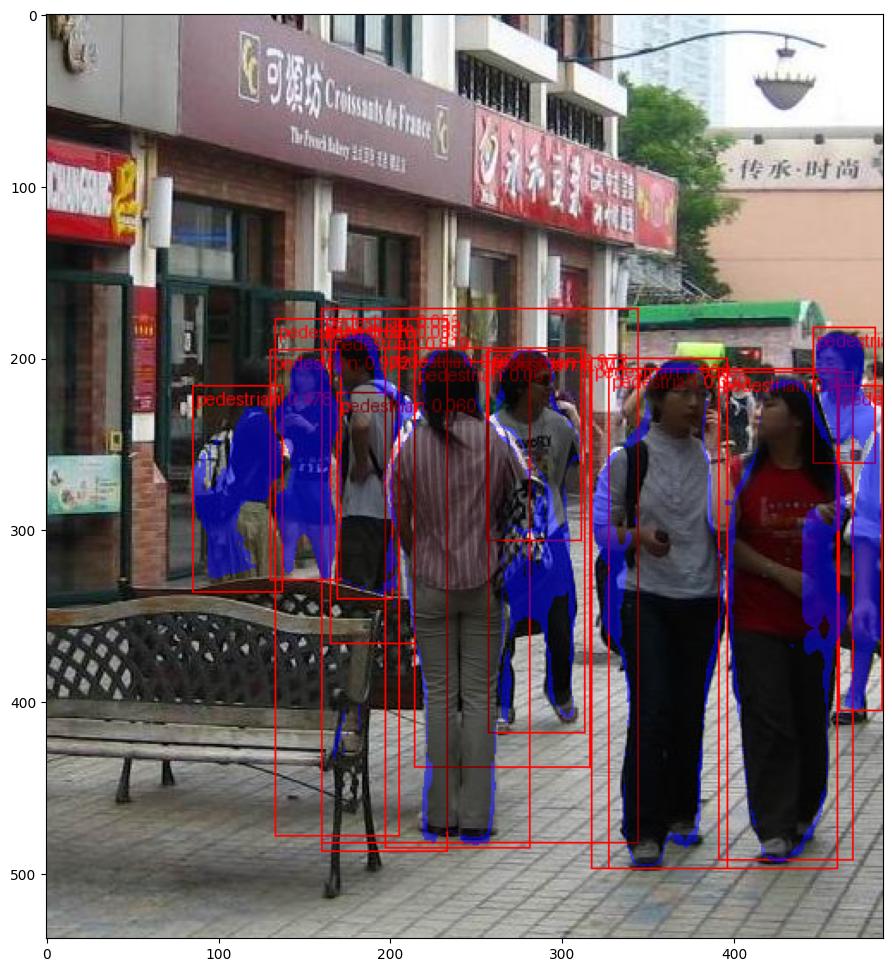

In [ ]:
import matplotlib.pyplot as plt
from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks

# Load the input image
image = read_image("data/PennFudanPed/PNGImages/FudanPed00045.png")
eval_transform = get_transform(train=False)

model.eval()
with torch.no_grad():
    x = eval_transform(image)
    # convert RGBA -> RGB and move to device
    x = x[:3, ...].to(device)
    # Get model predictions
    predictions = model([x, ])
    pred = predictions[0]

# Normalize image to 0-255 range and convert to uint8 format
image = (255.0 * (image - image.min()) / (image.max() - image.min())).to(torch.uint8)
# Keep only RGB channels
image = image[:3, ...]
# Create labels for detected pedestrians with confidence scores
pred_labels = [f"pedestrian: {score:.3f}" for label, score in zip(pred["labels"], pred["scores"])]
# Get predicted bounding box coordinates
pred_boxes = pred["boxes"].long()
output_image = draw_bounding_boxes(image, pred_boxes, pred_labels, colors="red")

# Create binary masks for segmentation (threshold at 0.7)
masks = (pred["masks"] > 0.7).squeeze(1)
# Draw segmentation masks on the image in blue color with 50% transparency
output_image = draw_segmentation_masks(output_image, masks, alpha=0.5, colors="blue")

# Display the final image with detections and segmentation
plt.figure(figsize=(12, 12))
plt.imshow(output_image.permute(1, 2, 0))

### **Evaluation:** Perform evaluation on the entire test set and report AP, mAP@.5, and mAP@[.5,.95]. What measures can be taken to importance the model performance?

#(Optional)Write the Faster-RCNN algorithm from scratch

After completing the above tasks, you can also try building Faster-RCNN from scratch.

You can get reference from the implementation of [Faster RCNN](https://github.com/explainingai-code/FasterRCNN-PyTorch ).

And try to implement it on CS GPU or your local environment

### View Original Faster-RCNN from the implementation：

The Faster RCNN includes components such as **Backbone**, **RPN** Network (Region Proposal Network), and **ROI Head**. You can try different Backbones and compare their performances:

***Tips: ***The reference implementation is based on VOC 2007 dataset, so you can make modifications to adapt to the Pedestrian dataset based on it.

#### Define Faster R-CNN model

In [ ]:
class FasterRCNN(nn.Module):
    def __init__(self, model_config, num_classes):
        super(FasterRCNN, self).__init__()
        self.model_config = model_config
        vgg16 = torchvision.models.vgg16(pretrained=True)
        self.backbone = vgg16.features[:-1]
        self.rpn = RegionProposalNetwork(model_config['backbone_out_channels'],
                                         scales=model_config['scales'],
                                         aspect_ratios=model_config['aspect_ratios'],
                                         model_config=model_config)
        self.roi_head = ROIHead(model_config, num_classes, in_channels=model_config['backbone_out_channels'])
        for layer in self.backbone[:10]:
            for p in layer.parameters():
                p.requires_grad = False
        self.image_mean = [0.485, 0.456, 0.406]
        self.image_std = [0.229, 0.224, 0.225]
        self.min_size = model_config['min_im_size']
        self.max_size = model_config['max_im_size']

    def normalize_resize_image_and_boxes(self, image, bboxes):
        dtype, device = image.dtype, image.device

        # Normalize
        mean = torch.as_tensor(self.image_mean, dtype=dtype, device=device)
        std = torch.as_tensor(self.image_std, dtype=dtype, device=device)
        image = (image - mean[:, None, None]) / std[:, None, None]

        # Resize image for  VOC 2007
        h, w = image.shape[-2:]
        im_shape = torch.tensor(image.shape[-2:])
        min_size = torch.min(im_shape).to(dtype=torch.float32)
        max_size = torch.max(im_shape).to(dtype=torch.float32)
        scale = torch.min(float(self.min_size) / min_size, float(self.max_size) / max_size)
        scale_factor = scale.item()

        # Resize image based on scale computed
        image = torch.nn.functional.interpolate(
            image,
            size=None,
            scale_factor=scale_factor,
            mode="bilinear",
            recompute_scale_factor=True,
            align_corners=False,
        )

        if bboxes is not None:
            # Resize boxes by
            ratios = [
                torch.tensor(s, dtype=torch.float32, device=bboxes.device)
                / torch.tensor(s_orig, dtype=torch.float32, device=bboxes.device)
                for s, s_orig in zip(image.shape[-2:], (h, w))
            ]
            ratio_height, ratio_width = ratios
            xmin, ymin, xmax, ymax = bboxes.unbind(2)
            xmin = xmin * ratio_width
            xmax = xmax * ratio_width
            ymin = ymin * ratio_height
            ymax = ymax * ratio_height
            bboxes = torch.stack((xmin, ymin, xmax, ymax), dim=2)
        return image, bboxes

    def forward(self, image, target=None):
        old_shape = image.shape[-2:]
        if self.training:
            # Normalize and resize boxes
            image, bboxes = self.normalize_resize_image_and_boxes(image, target['bboxes'])
            target['bboxes'] = bboxes
        else:
            image, _ = self.normalize_resize_image_and_boxes(image, None)

        # Call backbone
        feat = self.backbone(image)

        # Call RPN and get proposals
        rpn_output = self.rpn(image, feat, target)
        proposals = rpn_output['proposals']

        # Call ROI head and convert proposals to boxes
        frcnn_output = self.roi_head(feat, proposals, image.shape[-2:], target)
        if not self.training:
            # Transform boxes to original image dimensions called only during inference
            frcnn_output['boxes'] = transform_boxes_to_original_size(frcnn_output['boxes'],
                                                                     image.shape[-2:],
                                                                     old_shape)
        return rpn_output, frcnn_output

#### **Try：** Add NMS（Non-Max Suppression） to filter overlapping detection boxes during the model inference phase

In [ ]:
from torchvision.ops import nms
class FasterRCNNWithNMS(torch.nn.Module):
  # nms_threshold: IoU threshold of NMS
  # score_threshold： Confidence threshold for detection box
  # 'try different threshold'
  def __init__(self, num_classes, nms_threshold= 0.5 , score_threshold=0.5):


  def forward(self, images, targets=None):


    #Apply NMS to the prediction results of each image



### **IMPLEMENT FROM SCRATCH:** Implement NMS from scratch. You can take inspiration from the [torch official implmentation of NMS](https://https://pytorch.org/vision/main/_modules/torchvision/ops/boxes.html#nms).